In [46]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv("../data/clean/merged.csv")
#df = pd.read_csv("../data/clean/teams.csv") # TESTING

# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})
df.head()

,playerID,year,award_points,tmID,avg_height,avg_weight,avg_pl_efficiency,stint_coach,award_points_coach,mean_wins_coach,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,post_W,post_L
0,arcaija01w,1,0.0,HOU,72.333333,156.666667,25.1625,0,0.0,6.600000,...,32,14,2,13,3,17,4,6475,6.0,0.0
1,arcaija01w,2,6.0,HOU,72.500000,162.500000,18.0250,0,0.0,1.266667,...,32,11,5,8,8,13,8,6450,0.0,2.0
2,arcaija01w,3,0.0,HOU,73.500000,157.000000,16.5075,0,0.0,2.500000,...,32,14,2,10,6,16,5,6425,1.0,2.0
3,arcaija01w,4,0.0,HOU,73.500000,157.000000,14.9040,0,0.0,1.312500,...,34,14,3,6,11,14,10,6825,1.0,2.0
4,arcaija01w,6,0.0,HOU,72.333333,160.333333,15.1700,0,0.0,1.166667,...,34,11,6,8,9,11,11,6875,2.0,3.0


### Label Encoding

In [48]:
from sklearn.preprocessing import LabelEncoder

def encode_df(df):
    le = LabelEncoder()
    tmID_mapping = {} 
    
    for col, col_type in df.dtypes.items():
        if col_type == 'object' or col_type == 'datetime64[ns]':
            # store mapping if the column is 'tmID'
            if col == 'tmID':
                df[col] = le.fit_transform(df[col])
                tmID_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            else:
                df[col] = le.fit_transform(df[col])
                
    return df, tmID_mapping

# Use the function to encode the dataframe and get the tmID mapping
df, tmID_mapping = encode_df(df)


df.head( 10)

,playerID,year,award_points,tmID,avg_height,avg_weight,avg_pl_efficiency,stint_coach,award_points_coach,mean_wins_coach,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,post_W,post_L
0,0,1,0.0,6,72.333333,156.666667,25.162500,0,0.0,6.600000,...,32,14,2,13,3,17,4,6475,6.0,0.0
1,0,2,6.0,6,72.500000,162.500000,18.025000,0,0.0,1.266667,...,32,11,5,8,8,13,8,6450,0.0,2.0
2,0,3,0.0,6,73.500000,157.000000,16.507500,0,0.0,2.500000,...,32,14,2,10,6,16,5,6425,1.0,2.0
3,0,4,0.0,6,73.500000,157.000000,14.904000,0,0.0,1.312500,...,34,14,3,6,11,14,10,6825,1.0,2.0
4,0,6,0.0,6,72.333333,160.333333,15.170000,0,0.0,1.166667,...,34,11,6,8,9,11,11,6875,2.0,3.0
5,1,7,7.0,10,72.000000,179.000000,19.440000,2,0.0,0.100000,...,34,8,9,2,15,6,14,6825,0.0,0.0
6,1,7,7.0,10,72.000000,179.000000,19.440000,1,0.0,0.642857,...,34,8,9,2,15,6,14,6825,0.0,0.0
7,1,8,0.0,10,72.000000,179.000000,25.530000,0,0.0,0.416667,...,34,7,10,3,14,8,14,6875,0.0,0.0
8,1,9,0.0,10,71.500000,166.500000,12.690000,0,0.0,0.888889,...,34,9,8,7,10,8,12,6900,0.0,0.0
9,1,10,0.0,10,71.000000,157.666667,3.193333,0,0.0,0.700000,...,34,9,8,5,12,7,13,6875,0.0,0.0


In [49]:
def calculate_class_distribution_similarity(df, y_train, y_test):
    # Step 1: Calculate class distribution in the original dataset
    original_class_distribution = df['playoff'].value_counts(normalize=True)
    print("Original Class Distribution:")
    print(original_class_distribution)

    # Step 2: Calculate class distribution in the training and test sets
    train_class_distribution = y_train.value_counts(normalize=True)
    test_class_distribution = y_test.value_counts(normalize=True)

    print("\nTraining Set Class Distribution:")
    print(train_class_distribution)
    print("\nTest Set Class Distribution:")
    print(test_class_distribution)

    # Step 3: Compare class distributions
    class_distribution_similarity = (train_class_distribution - test_class_distribution).abs().sum()
    print("\nClass Distribution Similarity Score:", class_distribution_similarity)

    return class_distribution_similarity

# Update the train_model function to include imputation
def train_model(df, year):
    # Remove rows with missing values
    df.dropna(inplace=True)

    teams_df_train = df[df['year'] < year]
    teams_df_test = df[df['year'] == year]

    X_train = teams_df_train.drop("playoff", axis=1)  # Features
    y_train = teams_df_train["playoff"]  # Target variable

    X_test = teams_df_test.drop("playoff", axis=1)  # Features
    y_test = teams_df_test["playoff"]  # Target variable

    print(f"\nTrain/Test size for year={year}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, y_train, X_test, y_test

# create a final dataset with the predictions: team, playoff, prediction (a probability between 0 and 1)
def create_predictions(df, year, model, distribution_similarity=True):
    # Create a copy of the original dataset
    new_df = df.copy()

    X_train, y_train, X_test, y_test = train_model(new_df, year)

    # Check if the class distribution is similar between the training and test sets
    if distribution_similarity:
        calculate_class_distribution_similarity(new_df, y_train, y_test)    

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # Predictions
    y_pred_proba = model.predict_proba(X_test) # Prediction probabilities

    # Only add predictions to the test set
    new_df.loc[new_df['year'] == year, 'prediction'] = y_pred
    new_df.loc[new_df['year'] == year, 'prediction_proba'] = y_pred_proba[:,1]

    # Filter the dataset to only include the year we are interested in
    new_df = new_df[new_df['year'] == year]

    # Convert the predictions to integers
    new_df['prediction'] = new_df['prediction'].astype(int)

    return new_df


Training model: Logistic Regression

Train/Test size for year=2: (24, 57) (31, 57) (24,) (31,)

Train/Test size for year=3: (55, 57) (41, 57) (55,) (41,)

Train/Test size for year=4: (96, 57) (41, 57) (96,) (41,)

Train/Test size for year=5: (137, 57) (43, 57) (137,) (43,)

Train/Test size for year=6: (180, 57) (42, 57) (180,) (42,)

Train/Test size for year=7: (222, 57) (35, 57) (222,) (35,)

Train/Test size for year=8: (257, 57) (35, 57) (257,) (35,)

Train/Test size for year=9: (292, 57) (37, 57) (292,) (37,)

Train/Test size for year=10: (329, 57) (47, 57) (329,) (47,)

Training model: Random Forest

Train/Test size for year=2: (24, 57) (31, 57) (24,) (31,)

Train/Test size for year=3: (55, 57) (41, 57) (55,) (41,)

Train/Test size for year=4: (96, 57) (41, 57) (96,) (41,)

Train/Test size for year=5: (137, 57) (43, 57) (137,) (43,)

Train/Test size for year=6: (180, 57) (42, 57) (180,) (42,)

Train/Test size for year=7: (222, 57) (35, 57) (222,) (35,)

Train/Test size for year=8:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R


Training model: Support Vector Machine

Train/Test size for year=2: (24, 57) (31, 57) (24,) (31,)

Train/Test size for year=3: (55, 57) (41, 57) (55,) (41,)

Train/Test size for year=4: (96, 57) (41, 57) (96,) (41,)

Train/Test size for year=5: (137, 57) (43, 57) (137,) (43,)

Train/Test size for year=6: (180, 57) (42, 57) (180,) (42,)

Train/Test size for year=7: (222, 57) (35, 57) (222,) (35,)

Train/Test size for year=8: (257, 57) (35, 57) (257,) (35,)

Train/Test size for year=9: (292, 57) (37, 57) (292,) (37,)

Train/Test size for year=10: (329, 57) (47, 57) (329,) (47,)

Training model: Neural Network

Train/Test size for year=2: (24, 57) (31, 57) (24,) (31,)

Train/Test size for year=3: (55, 57) (41, 57) (55,) (41,)

Train/Test size for year=4: (96, 57) (41, 57) (96,) (41,)

Train/Test size for year=5: (137, 57) (43, 57) (137,) (43,)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=6: (180, 57) (42, 57) (180,) (42,)

Train/Test size for year=7: (222, 57) (35, 57) (222,) (35,)

Train/Test size for year=8: (257, 57) (35, 57) (257,) (35,)

Train/Test size for year=9: (292, 57) (37, 57) (292,) (37,)

Train/Test size for year=10: (329, 57) (47, 57) (329,) (47,)


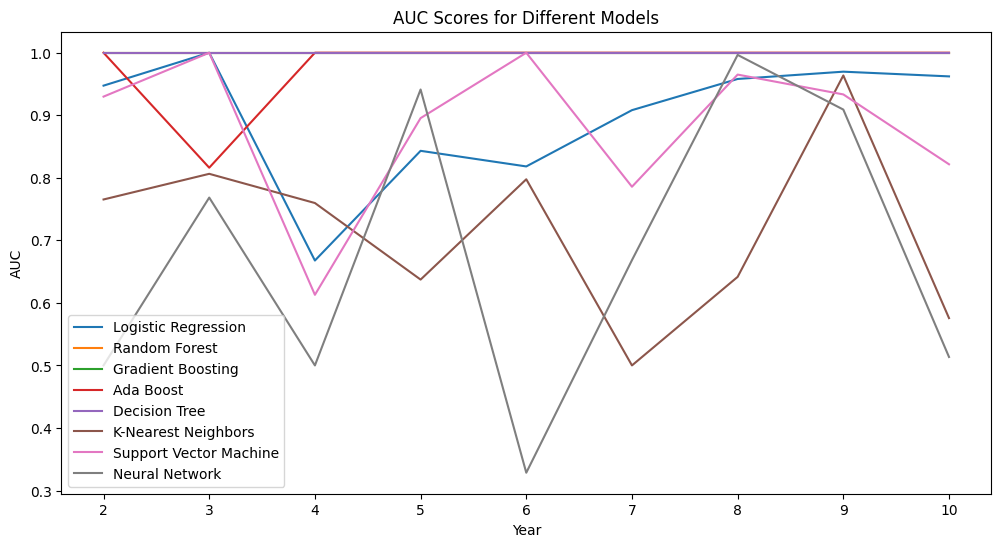

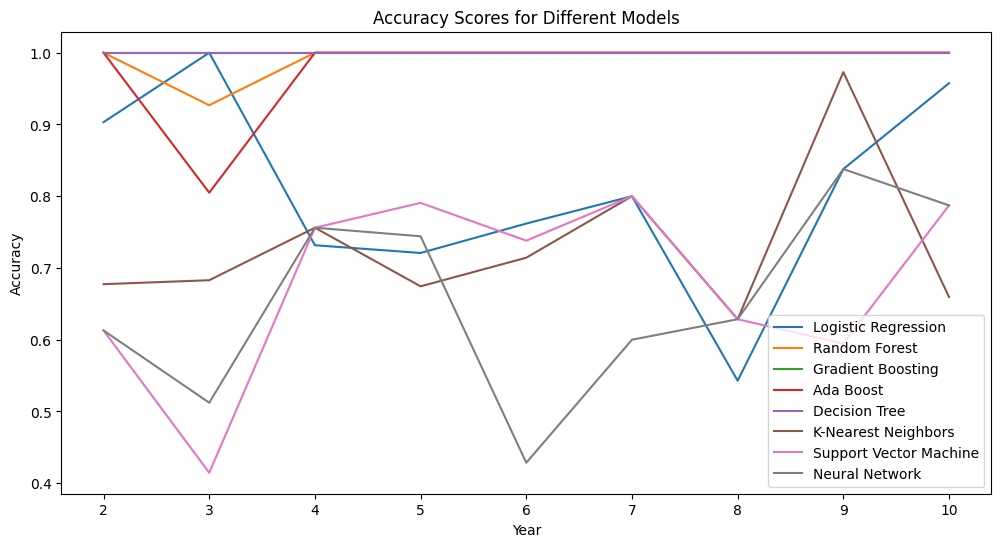

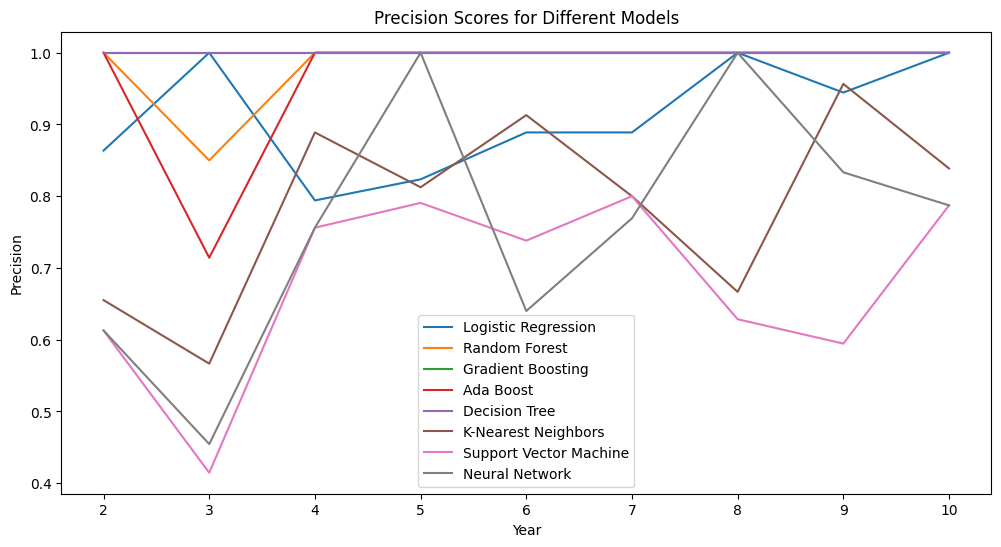

In [50]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier()
}

min_year = 2
max_year = 10

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []

    for i in range(min_year, max_year + 1):
        new_df = create_predictions(df, i, model, distribution_similarity=False)
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models")
plt.legend()
plt.show()

In [51]:
# Create predictions for the best model
best_model = GradientBoostingClassifier() # An example of the best model

def create_final_predictions(df, year):
    # Select the best 4 teams for each conference (confID) ensuring unique teams
    final_predictions = df[df['year'] == year].sort_values(by='prediction_proba', ascending=False).drop_duplicates(subset='tmID').groupby('confID').head(4)

    # remove confID column
    final_predictions.drop(['year', 'playoff', 'confID'], axis=1, inplace=True)

    return final_predictions

# Add the tmID mapping to the final predictions so the final predictions have the team names
def convert_tmID_to_team(df, tmID_mapping):
    # Create a reverse mapping from the encoded numbers to the team names
    reverse_mapping = {v: k for k, v in tmID_mapping.items()}
    # Map the encoded tmID to the team names
    df['tmID'] = df['tmID'].map(reverse_mapping)
    return df

# Usage of the function within the loop
for i in range(min_year, max_year + 1):
    new_df = create_predictions(df, i, best_model, distribution_similarity=False)
    new_df = create_final_predictions(new_df, i)
    new_df.drop(new_df.columns.difference(['tmID', 'confID', 'year', 'playoff', 'prediction', 'prediction_proba']), axis=1, inplace=True)
    new_df = convert_tmID_to_team(new_df, tmID_mapping)
    new_df.to_csv(f"../data/predictions/predictions_{i}.csv", index=False)


Train/Test size for year=2: (24, 57) (31, 57) (24,) (31,)

Train/Test size for year=3: (55, 57) (41, 57) (55,) (41,)

Train/Test size for year=4: (96, 57) (41, 57) (96,) (41,)

Train/Test size for year=5: (137, 57) (43, 57) (137,) (43,)

Train/Test size for year=6: (180, 57) (42, 57) (180,) (42,)

Train/Test size for year=7: (222, 57) (35, 57) (222,) (35,)

Train/Test size for year=8: (257, 57) (35, 57) (257,) (35,)

Train/Test size for year=9: (292, 57) (37, 57) (292,) (37,)

Train/Test size for year=10: (329, 57) (47, 57) (329,) (47,)
